In [1]:
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
import cv2
import tifffile as tiff
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow import keras
import os
import pandas as pd

In [2]:

def get_inception(inp, filt):
    #inp = Input((224,224,3))
    #1X1 conv
    conv1 = Conv2D(filters = int(filt/4),kernel_size = (1,1), padding = 'same', kernel_initializer = 'he_normal')(inp)
    conv1 = Activation('relu')(conv1)
    conv1 = BatchNormalization()(conv1)

    #1X1_3X3 conv
    conv2 = Conv2D(filters = int(filt/4),kernel_size = (1,1), padding = 'same', kernel_initializer = 'he_normal')(inp)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(filters = int(filt/4),kernel_size = (3,3), padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = BatchNormalization()(conv2)

    #1X1_5X5 conv
    conv3 = Conv2D(filters = int(filt/4),kernel_size = (1,1), padding = 'same', kernel_initializer = 'he_normal')(inp)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(filters = int(filt/4),kernel_size = (5,5), padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = BatchNormalization()(conv3)

    #3X3 maxpool 1X1 conv
    pool4 = tf.nn.max_pool2d(inp, ksize = (3,3), strides=1, padding='SAME')
    conv4 = Conv2D(filters = int(filt/4),kernel_size = (1,1), padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv4 = Activation('relu')(conv4)
    conv4 = BatchNormalization()(conv4)

    concat = concatenate([conv1, conv2, conv3, conv4])
    return(concat)

In [3]:
def get_Model():
    inpt = Input((224,224,3))
    print(inpt.shape)
    conv1 = get_inception(inpt, 64)
    conv1 = get_inception(conv1, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2), strides = 2)(conv1)
    
    conv2 = get_inception(pool1, 128)
    conv2 = get_inception(conv2, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2), strides = 2)(conv2)
    
    conv3 = get_inception(pool2, 256)
    conv3 = get_inception(conv3, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2), strides = 2)(conv3)
    
    conv4 = get_inception(pool3, 512)
    conv4 = get_inception(conv4, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2), strides = 2)(conv4)

    conv5 = get_inception(pool4, 1024)
    conv5 = get_inception(conv5, 1024)
    
    up1 = Conv2DTranspose(512, (2, 2), strides=2, padding='same')(conv5)
    up1 = concatenate([up1,conv4])
    conv6 = get_inception(up1, 512)
    conv6 = get_inception(conv6, 512)
    
    up2 = Conv2DTranspose(256, (2, 2), strides=2, padding='same')(conv6)
    up2 = concatenate([up2,conv3])
    conv7 = get_inception(up2, 256)
    conv7 = get_inception(conv7, 256)
    
    up3 = Conv2DTranspose(128, (2, 2), strides=2, padding='same')(conv7)
    up3 = concatenate([up3,conv2])
    conv8 = get_inception(up3, 128)
    conv8 = get_inception(conv8, 128)

    up4 = Conv2DTranspose(64, (2, 2), strides=2, padding='same')(conv8)
    up4 = concatenate([up4,conv1])
    conv9 = get_inception(up4, 64)
    conv9 = get_inception(conv9, 64)


    conv = Conv2D(3, (1,1), activation='softmax', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    print(conv.shape)

    model = Model(inpt, conv)
    model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [4]:
model = get_Model()

(None, 224, 224, 3)
(None, 224, 224, 3)


In [5]:
model.load_weights('incepunet_224X224X3_1000itr.h5')

In [10]:
train_wkt = pd.read_csv('./train_wkt_v4.csv')
img_ids = train_wkt['ImageId'].unique()
img_ids

array(['6040_2_2', '6120_2_2', '6120_2_0', '6090_2_0', '6040_1_3',
       '6040_1_0', '6100_1_3', '6010_4_2', '6110_4_0', '6140_3_1',
       '6110_1_2', '6100_2_3', '6150_2_3', '6160_2_1', '6140_1_2',
       '6110_3_1', '6010_4_4', '6170_2_4', '6170_4_1', '6170_0_4',
       '6060_2_3', '6070_2_3', '6010_1_2', '6040_4_4', '6100_2_2'],
      dtype=object)

(<Figure size 988.8x604.8 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x1bb3b99aa20>)

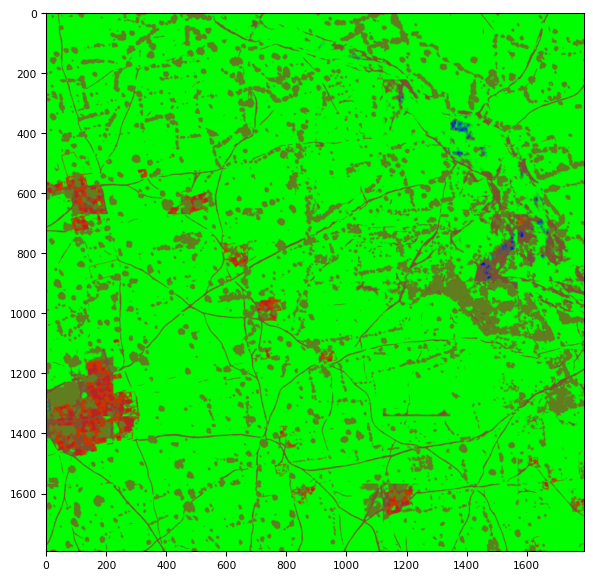

In [45]:
data = tiff.imread(r'./three_band/6030_0_0.tif').transpose([1, 2, 0])
w,h = data.shape[:2]
split = []
hstart = 0
for i in range(1,9):
    hend = (h/8)*i
    wstart=0 
    
    temp = []
    for j in range(1,9):
        wend = (w/8)*j
        test= data[int(hstart):int(hend), int(wstart):int(wend)]
        img = cv2.resize(test,(224,224), cv2.INTER_AREA)
        img = img/np.max(img)
        #alpha = np.ones(img.shape[:2])
        #rgba = cv2.merge([img[:,:,0], img[:,:,1], img[:,:,2], alpha])
        pred = model.predict(np.reshape(img, (-1,224,224,3)))
        pred = pred[0,:,:,:3]
        pred = pred * 255
        temp.append(pred)
        wstart = wend
    split.append(np.concatenate([temp[0],temp[1],temp[2],temp[3],temp[4],temp[5],temp[6],temp[7]], axis=1))
    hstart = hend
pred = np.concatenate([split[0],split[1],split[2],split[3],split[4],split[5],split[6],split[7]], axis=0)
tiff.imshow(pred)

(<Figure size 988.8x604.8 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x1bb0f0db240>)

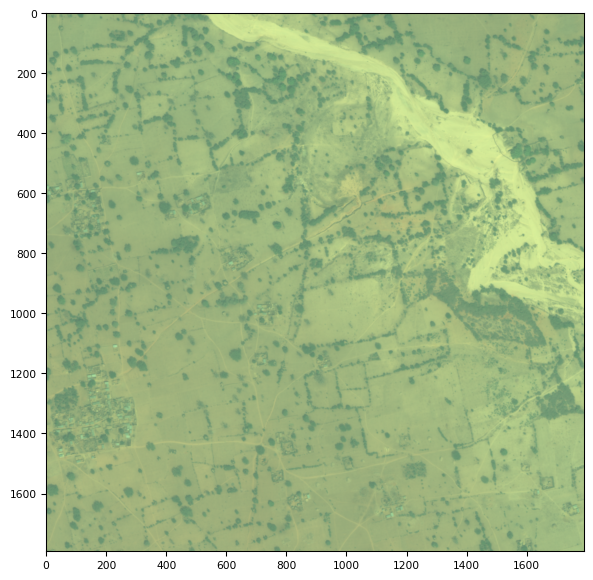

In [44]:
img = tiff.imread(r'./three_band/6030_0_0.tif').transpose([1, 2, 0])
tiff.imshow(cv2.resize(img,(1792,1792), cv2.INTER_AREA))